In [57]:
import matplotlib
matplotlib.rcParams['savefig.dpi']

'figure'

In [58]:
import yaml
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import pathlib
sys.path += ['..']

import templating


with open('../data-config.yaml') as f:
    config = yaml.load(f)
    
datasets = ['dengue', 'rsv2']
out_dir = pathlib.Path('..') / config['out_dir']
template_builders = [templating.TemplateBuilder(out_dir / dataset) for dataset in datasets]
    
config

/usr/lib/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  del sys.path[0]


{'beast_jar': 'lib/feast.jar',
 'lsd_executable': 'lsd',
 'relaxed_clock': False,
 'mutation_rate': 0.0005,
 'rate_sd': None,
 'chain_length': 2000000,
 'log_every': 1000,
 'estimate_clock_rate': False,
 'prior_params': {'pop_size': {'m': 2, 's': 2},
  'kappa': {'m': 1.0, 's': 1.25}},
 'init_values': {'clock_rate': 1.0, 'pop_size': 10, 'kappa': 2.0},
 'estimate_topology': True,
 'n_iter': 30000,
 'inference': 'mean_field',
 'burn_in': 0.1,
 'n_runs': 100,
 'out_dir': 'out-data',
 'datasets': {'dengue': 'Dengue4.env.nex', 'rsv2': 'RSV2.nex'},
 'seed': 1}

In [80]:
import pandas as pd
import pathlib

def get_beast_trace(template_builder):
    return pd.read_table(template_builder.beast_analysis_trace_path, sep='\t', comment='#') 

beast_traces = [get_beast_trace(template_builder) for template_builder in template_builders]
beast_traces

/usr/lib/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead.
  """


[       Sample    posterior   likelihood       prior  treeLikelihood  \
 0           0 -4136.361693 -4004.637863 -131.723830    -4004.637863   
 1        1000 -4024.350997 -3936.469802  -87.881195    -3936.469802   
 2        2000 -4025.204669 -3936.188179  -89.016490    -3936.188179   
 3        3000 -4023.322495 -3937.091037  -86.231458    -3937.091037   
 4        4000 -3956.738557 -3869.112143  -87.626414    -3869.112143   
 5        5000 -3958.395598 -3869.792542  -88.603056    -3869.792542   
 6        6000 -3952.478143 -3860.949502  -91.528642    -3860.949502   
 7        7000 -3957.919143 -3867.539118  -90.380025    -3867.539118   
 8        8000 -3949.599419 -3859.874222  -89.725197    -3859.874222   
 9        9000 -3950.176024 -3859.684376  -90.491647    -3859.684376   
 10      10000 -3949.800773 -3860.241301  -89.559472    -3860.241301   
 11      11000 -3947.637106 -3855.441448  -92.195658    -3855.441448   
 12      12000 -3947.883475 -3856.857637  -91.025838    -3856.85

In [81]:
beast_fixed_traces = [pd.read_table(template_builder.out_path / 'beast-fixed-log.log', sep='\t', comment='#') for template_builder in template_builders]

/usr/lib/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [83]:
import pickle

def get_pymc_result(template_builder):
    with open(template_builder.out_path / 'pymc_approx.pickle', 'rb') as f:
        return pickle.load(f)

pymc_results = [get_pymc_result(template_builder) for template_builder in template_builders]
pymc_results

In [84]:
import variational_analysis
import templating
import topology_inference
import io
import Bio.Phylo
import Bio.AlignIO
import newick
import pylo.topology
import pylo.tree.transform
import scipy.stats
import numpy as np

data_dir = pathlib.Path('../data')

def newick_from_bio(bio_tree):
    newick_io = io.StringIO()
    Bio.Phylo.write([bio_tree], newick_io, format='newick')
    return newick_io.getvalue()
 

def get_pymc_marginals(dataset, template_builder, approx):
    lsd_tree = topology_inference.extract_lsd_tree(template_builder)
    analysis_newick = newick_from_bio(lsd_tree)
    tree = newick.loads(analysis_newick)[0]
    topology = pylo.topology.TreeTopology(tree)
    
    tree_height_mean = approx.groups[0].bij.rmap(approx.mean.eval())['tree_tree_height_proportion__'][-1]
    tree_height_std = approx.groups[0].bij.rmap(approx.std.eval())['tree_tree_height_proportion__'][-1]
    delta = 0.01
    n_sds = 4
    tree_height_x = np.arange(tree_height_mean - tree_height_std * n_sds, tree_height_mean + tree_height_std * n_sds, delta)
    
    pop_size_mean = approx.groups[0].bij.rmap(approx.mean.eval())['pop_size_log__']
    pop_size_std = approx.groups[0].bij.rmap(approx.std.eval())['pop_size_log__']
    pop_size_x = np.arange(pop_size_mean - pop_size_std * n_sds, pop_size_mean + pop_size_std * n_sds, delta)
    
    
    return {
        'Tree height': (np.exp(tree_height_x) + topology.get_max_leaf_height(), scipy.stats.norm.pdf(tree_height_x, loc=tree_height_mean, scale=tree_height_std) / np.exp(tree_height_x)),
        'Coalescent population size': (np.exp(pop_size_x), scipy.stats.norm.pdf(pop_size_x, loc=pop_size_mean, scale=pop_size_std) / np.exp(pop_size_x))
    }
    

pymc_marginals = [get_pymc_marginals(dataset, template_builder, tracker) for dataset, template_builder, tracker in zip(datasets, template_builders, pymc_results)]
pymc_marginals

[{'Tree height': (array([ 76.97363266,  77.36532398,  77.76095186,  78.16055587,
           78.56417596,  78.97185251,  79.38362627,  79.79953843,
           80.21963057,  80.64394471,  81.07252328,  81.50540914,
           81.94264557,  82.38427629,  82.83034549,  83.28089775,
           83.73597813,  84.19563216,  84.65990578,  85.12884542,
           85.60249799,  86.08091085,  86.56413184,  87.05220928,
           87.54519198,  88.04312923,  88.54607084,  89.0540671 ,
           89.5671688 ,  90.08542726,  90.60889431,  91.13762228,
           91.67166407,  92.21107306,  92.7559032 ,  93.30620897,
           93.86204541,  94.4234681 ,  94.99053318,  95.56329736,
           96.14181792,  96.7261527 ,  97.31636015,  97.91249928,
           98.5146297 ,  99.12281164,  99.73710591, 100.35757394,
          100.98427778, 101.61728009, 102.25664418, 102.90243399,
          103.5547141 , 104.21354973, 104.87900676, 105.55115175,
          106.23005192, 106.91577514, 107.60838999, 108.30796

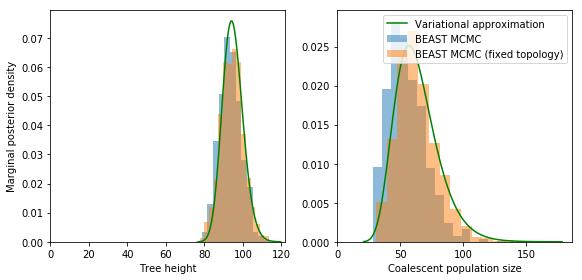

In [77]:
beast_variable_mapping = { 'Tree height': 'TreeHeight' ,'Coalescent population size': 'popSize' }
def marginal_plot_for_dataset(beast_trace_df, beast_fixed_trace_df, dataset_pymc_marginals):
    fig, axs = plt.subplots(figsize=(8,4), ncols=2)
    for varname, ax in zip(beast_variable_mapping.keys(), axs):
        ax.set_xlabel(varname)
        ax.hist(beast_trace_df[beast_variable_mapping[varname]][int(beast_trace_df.shape[0]*config['burn_in']):], bins=15, alpha=0.5, density=True, label='BEAST MCMC')
        ax.hist(beast_fixed_trace_df[beast_variable_mapping[varname]][int(beast_fixed_trace_df.shape[0]*config['burn_in']):], bins=15, alpha=0.5, density=True, label='BEAST MCMC (fixed topology)')
        ax.plot(*dataset_pymc_marginals[varname], color='green', label='Variational approximation')
        ax.set_xlim(left=0)
        plt.tight_layout()
    
    axs[0].set_ylabel('Marginal posterior density')
    axs[1].legend(loc='upper right')
        
marginal_plot_for_dataset(beast_traces[0], beast_fixed_traces[0], pymc_marginals[0])
plt.savefig('out/{0}_marginals.pdf'.format(datasets[0]))

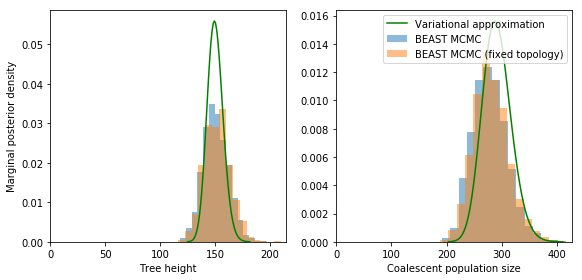

In [85]:
marginal_plot_for_dataset(beast_traces[1], beast_fixed_traces[1], pymc_marginals[1])


plt.savefig('out/{0}_marginals.pdf'.format(datasets[1]))

## Timing

In [66]:
def get_pymc_tracker(template_builder):
    with open(template_builder.pymc_analysis_result_path, 'rb') as f:
        return pickle.load(f)

pymc_trackers = [get_pymc_tracker(template_builder) for template_builder in template_builders]

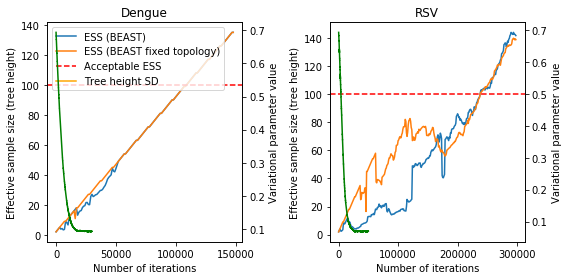

In [79]:
import pymc3 as pm

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

to_includes = [150000, 300000]

tidy_dataset_names = { 'dengue': 'Dengue', 'rsv2': 'RSV' }

plt.locator_params(axis='x', nbins=5)

for dataset, ax, beast_trace, beast_fixed_trace, approx, tracker, to_include in zip(datasets, axs, beast_traces, beast_fixed_traces, pymc_results, pymc_trackers, to_includes):
    ess = beast_trace['ESS(TreeHeight.)'][1:int(to_include/config['log_every'])].astype(float)
    ess_fixed = beast_fixed_trace['ESS(TreeHeight.)'][1:int(to_include/config['log_every'])].astype(float)
    ax.plot(np.arange(len(ess))*config['log_every'], ess, label='ESS (BEAST)')
    ax.plot(np.arange(len(ess_fixed))*config['log_every'], ess_fixed, label='ESS (BEAST fixed topology)')
    min_ess_line = ax.axhline(100, color='red', linestyle='dashed', label='Acceptable ESS')
    ax.set_title(tidy_dataset_names[dataset])
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('Effective sample size (tree height)')
    ax2 = ax.twinx()
    ax2.set_ylabel('Variational parameter value')
    
    tree_height_stds = [approx.groups[0].bij.rmap(np.log(1 + np.exp(rho)))['tree_tree_height_proportion__'][-1] for rho in tracker.hist['rho'][:to_include]]
    
    std_line = ax2.plot(tree_height_stds, color='green')
    ax.plot([], color='orange', label='Tree height SD')

axs[0].legend()
plt.tight_layout()

plt.savefig('out/timing.pdf')

In [68]:
len(beast_traces[1])

2001

In [69]:
pymc_results[1].groups[0].bij.ordering.vmap

[VarMap(var='kappa_log__', slc=slice(0, 1, None), shp=(), dtyp='float64'),
 VarMap(var='pop_size_log__', slc=slice(1, 2, None), shp=(), dtyp='float64'),
 VarMap(var='pi_stickbreaking__', slc=slice(2, 5, None), shp=(3,), dtyp='float64'),
 VarMap(var='tree_tree_height_proportion__', slc=slice(5, 133, None), shp=(128,), dtyp='float64')]

In [70]:
pymc_trackers[1].hist['rho'][1].shape

(133,)

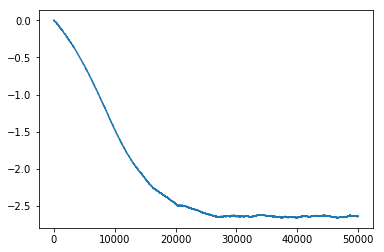

In [71]:
plt.plot(np.stack(pymc_trackers[1].hist['rho'])[:, 132]);